In [68]:
import random
from collections import defaultdict
from itertools import combinations, product, chain

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx

from agent import Student, Course
from matching import *
from simulate import * 

%matplotlib inline

There are $m$ students, $n$ courses, and $d$ departments.

Students may come from any of the $4$ class years: freshmen, sophomores, juniors, and seniors. Randomly assign the students to these four class years. In addition, randomly assign the students to the departments.

The courses may come from any of the $d$ departments. Randomly assign the courses to the departments (may have higher sampling weights for courses in the department that the student is in)

Next, generate random preference orders for students: rankings of the $n$ courses.

Also, generate preference orders over students for the courses in the following manner: courses prefer students from their own department, prefer students from higher class years than lower class years; in case of ties, break arbitrarily.


TODO: Need to define utilities of students

linear utility in the order of preferences

In [69]:
n_students = 5000
n_courses = 100
n_depts = 15
credit_limit = 4
enroll_limit = 80
n_slots = 12

student_list, course_list = generate_data(n_students = n_students, 
                                          n_courses = n_courses, 
                                          n_depts = n_depts, 
                                          credit_limit = credit_limit,
                                          enroll_limit = enroll_limit)

# Student-proposing DA

Suppose $credit\_limit = 4$ for each student and $enroll\_limit = 80$.

In each round, a student $s$ proposes to their $credit\_limit$ most preferred courses. Then, the courses tentatively accept their $enroll\_limit$ most preferred students and reject the rest.

Students cannot propose to courses that they have been rejected. And courses only tentatively accept students that are more highly preferred. 

Repeat until no more proposal can be made

TODO: need assumption over the preferences (e.g. substitutability)

In [70]:
student_list, course_list = find_matching(student_list, course_list)

Round: 1
	Number of proposals made: 20000
	Number of proposals being rejected: 12000
Round: 2
	Number of proposals made: 12000
	Number of proposals being rejected: 12000
Round: 3
	Number of proposals made: 12000
	Number of proposals being rejected: 12000
Round: 4
	Number of proposals made: 12000
	Number of proposals being rejected: 12000
Round: 5
	Number of proposals made: 12000
	Number of proposals being rejected: 12000
Round: 6
	Number of proposals made: 12000
	Number of proposals being rejected: 12000
Round: 7
	Number of proposals made: 12000
	Number of proposals being rejected: 12000
Round: 8
	Number of proposals made: 12000
	Number of proposals being rejected: 12000
Round: 9
	Number of proposals made: 12000
	Number of proposals being rejected: 12000
Round: 10
	Number of proposals made: 12000
	Number of proposals being rejected: 12000
Round: 11
	Number of proposals made: 12000
	Number of proposals being rejected: 12000
Round: 12
	Number of proposals made: 12000
	Number of proposals

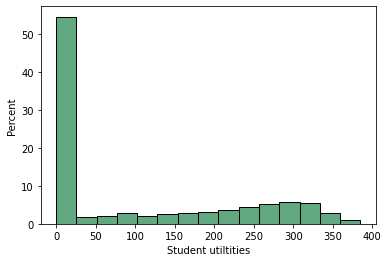

In [71]:
student_utilities = [s.get_utilities() for s in student_list]
sns.histplot(student_utilities, stat = 'percent', color = 'seagreen')
plt.xlabel("Student utiltities")
filename = f"results/fig/utils_match_s{n_students}c{n_courses}d{n_depts}cl{credit_limit}el{enroll_limit}k{n_slots}"
plt.savefig(filename)

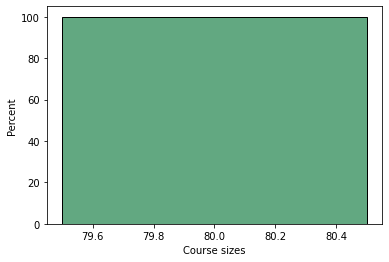

In [72]:
course_enroll_sizes = [len(c.student_enroll) for c in course_list]
sns.histplot(course_enroll_sizes, stat = 'percent', color = 'seagreen')
plt.xlabel("Course sizes")
filename = f"results/fig/csizes_match_s{n_students}c{n_courses}d{n_depts}cl{credit_limit}el{enroll_limit}k{n_slots}"
plt.savefig(filename)

## Sanity check

In [73]:
for c in course_list:
    for s in c.student_enroll:
        assert c.course_id in s.course_enroll
        
    assert len(c.student_enroll) <= c.enroll_limit

for s in student_list:
    assert len(s.course_enroll) <= s.credit_limit

# Course Scheduling

There are $k = 12$ time slots. Assume that rooms are unlimited.

For each course-time assignment, find the number of conflicts among students and pick the one with the minimum conflicts.

There are $k^n$ possible course-time assignments. -> NP-hard

**Maximum-weight k-cut problem**

Min weight between components, but we want max conflicts between components

Higher conflicts $c$ -> lower weights $w$

$w = -c + \max(c)$

But weights need to be positive so add $\max(c)$ 

https://en.wikipedia.org/wiki/Minimum_k-cut

https://cstheory.stackexchange.com/questions/50321/max-k-cut-with-negative-edge-weights

https://math.mit.edu/~goemans/18434S06/multicuts-brian.pdf

https://neo4j.com/docs/graph-data-science/current/algorithms/approx-max-k-cut/

https://www.math.cmu.edu/~af1p/Texfiles/cuts.pdf

https://cs.gmu.edu/~lifei/teaching/cs684_spring12/multi-cut.pdf

https://www.geeksforgeeks.org/gomory-hu-tree-introduction/#

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.flow.gomory_hu_tree.html

https://courses.engr.illinois.edu/cs598csc/sp2009/lectures/lecture_7.pdf

In [74]:
conflict_counts = defaultdict(int)

for s in student_list:
    for c1, c2 in combinations(sorted(s.course_enroll), 2):
        conflict_counts[(c1, c2)] += 1

print(f"number of edges: {len(conflict_counts)}")

number of edges: 317


In [75]:
print(f"total number of conflicts: {sum(conflict_counts.values())}")

total number of conflicts: 10848


In [76]:
graph = nx.Graph()
graph.add_weighted_edges_from([(c[0], c[1], n * (-1) + max(conflict_counts.values())) 
                               for c, n in conflict_counts.items()])
print(f"Number of nodes: {graph.number_of_nodes()}")
print(f"Number of edges: {graph.number_of_edges()}")

Number of nodes: 100
Number of edges: 317


## Minimum-weight k-Cut Problem

Gomury-Hu approach for k-Cut$(G)$

1. Compute Gomury-Hu tree $T$ for $G$
2. Remove $k-1$ minimum weight (or lightest) edges from the Tree.
3. Return union of components obtained by above removal of edges.

Guarantee approximation ratio of $2 - \frac{2}{k}$

In [77]:
# nx.set_edge_attributes(graph, 1, "capacity")
T = nx.gomory_hu_tree(graph, capacity = 'weight')

In [78]:
# for node1, node2, data in T.edges(data = True):
#     print(f"({node1}, {node2}) with weight {data['weight']}")

In [79]:
min_weight_k_edges = sorted([e for e in T.edges(data = True)], 
                            key = lambda x: x[2]['weight'],
                            reverse = False)[: n_slots - 1]
for node1, node2, data in min_weight_k_edges:
    print(f"({node1}, {node2}) with weight {data['weight']}")

(99, 17) with weight 0
(73, 30) with weight 0
(87, 41) with weight 0
(90, 9) with weight 0
(71, 57) with weight 0
(81, 34) with weight 0
(78, 3) with weight 0
(6, 11) with weight 0
(23, 13) with weight 0
(77, 7) with weight 0
(8, 14) with weight 0


In [80]:
T.remove_edges_from(min_weight_k_edges)
components = list(nx.connected_components(T))
print(f"Number of components: {len(components)}")
for i, comp in enumerate(components):
    print(f"Component {i}: size = {len(comp)} -> {list(comp)}")

Number of components: 12
Component 0: size = 6 -> [99, 72, 12, 16, 85, 60]
Component 1: size = 11 -> [97, 35, 38, 39, 70, 73, 76, 17, 55, 29, 94]
Component 2: size = 3 -> [33, 30, 87]
Component 3: size = 8 -> [96, 5, 90, 41, 44, 79, 49, 26]
Component 4: size = 6 -> [65, 71, 9, 43, 15, 21]
Component 5: size = 4 -> [81, 57, 92, 63]
Component 6: size = 8 -> [34, 36, 46, 78, 80, 20, 86, 91]
Component 7: size = 8 -> [64, 66, 3, 6, 40, 48, 18, 95]
Component 8: size = 7 -> [11, 19, 23, 89, 58, 61, 25]
Component 9: size = 7 -> [98, 37, 42, 13, 77, 88, 28]
Component 10: size = 5 -> [7, 8, 10, 53, 56]
Component 11: size = 27 -> [0, 1, 2, 4, 14, 22, 24, 27, 31, 32, 45, 47, 50, 51, 52, 54, 59, 62, 67, 68, 69, 74, 75, 82, 83, 84, 93]


### Assign time to courses and resolve conflicts among students

In [81]:
for t, c_list in enumerate(components):
    for c in list(c_list):
        course_list[c].set_time(t)

for s in student_list:
    s.determine_conflicts(course_list)

In [82]:
student_list, course_list = resolve_conflicts(student_list, course_list)

Round: 1
	Number of proposals made: 17664
	Number of proposals being rejected: 17327
Round: 2
	Number of proposals made: 17327
	Number of proposals being rejected: 17121
Round: 3
	Number of proposals made: 17121
	Number of proposals being rejected: 16962
Round: 4
	Number of proposals made: 16962
	Number of proposals being rejected: 16745
Round: 5
	Number of proposals made: 16745
	Number of proposals being rejected: 16577
Round: 6
	Number of proposals made: 16577
	Number of proposals being rejected: 16355
Round: 7
	Number of proposals made: 16355
	Number of proposals being rejected: 16055
Round: 8
	Number of proposals made: 16055
	Number of proposals being rejected: 15824
Round: 9
	Number of proposals made: 15824
	Number of proposals being rejected: 15590
Round: 10
	Number of proposals made: 15590
	Number of proposals being rejected: 15405
Round: 11
	Number of proposals made: 15405
	Number of proposals being rejected: 15173
Round: 12
	Number of proposals made: 15173
	Number of proposals

In [83]:
# sanity checks
for c in course_list:
    for s in c.student_enroll:
        assert c.course_id in s.course_enroll
        
    assert len(c.student_enroll) <= c.enroll_limit

for s in student_list:
    assert len(s.course_enroll) <= s.credit_limit

In [84]:
# for s in student_list:
#     s.get_enrollment_info()
# for c in course_list:
#     c.get_enrollment_info()

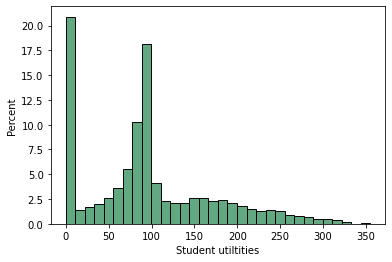

In [85]:
student_utilities = [s.get_utilities() for s in student_list]
total_welfare = sum(student_utilities)
sns.histplot(student_utilities, stat = 'percent', color = 'seagreen')
plt.xlabel("Student utiltities")
filename = f"results/fig/utils_resolve_s{n_students}c{n_courses}d{n_depts}cl{credit_limit}el{enroll_limit}k{n_slots}"
plt.savefig(filename)

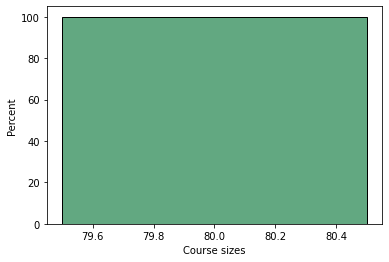

In [86]:
course_enroll_sizes = [len(c.student_enroll) for c in course_list]
sns.histplot(course_enroll_sizes, stat = 'percent', color = 'seagreen')
plt.xlabel("Course sizes")
filename = f"results/fig/csizes_resolve_s{n_students}c{n_courses}d{n_depts}cl{credit_limit}el{enroll_limit}k{n_slots}"
plt.savefig(filename)

# Baseline: traditional approach

course schedules are pre-determined (randomly) prior to registration

In [87]:
student_list_baseline = [Student(s.student_id, s.n_courses, s.year, s.dept, s.credit_limit)
                         for s in student_list]
# copy course prefs
for s, s_baseline in zip(student_list, student_list_baseline):
    s_baseline.course_prefs = s.course_prefs.copy()
    

course_list_baseline = [Course(c.course_id, [], c.dept, c.enroll_limit)
                         for c in course_list]
# copy student prefs
for c, c_baseline in zip(course_list, course_list_baseline):
    c_baseline.student_prefs = [student_list_baseline[s.student_id] for s in c.student_prefs]
    c_baseline.student_prefs_dict = {student.student_id: index 
                                   for index, student in enumerate(c_baseline.student_prefs)}

Randomly assign times for courses

In [88]:
for c_baseline in course_list_baseline:
    c_baseline.set_time(np.random.randint(k))
    
student_list_baseline, course_list_baseline = resolve_conflicts(student_list_baseline, course_list_baseline)

Round: 1
	Number of proposals made: 20000
	Number of proposals being rejected: 19680
Round: 2
	Number of proposals made: 19680
	Number of proposals being rejected: 19360
Round: 3
	Number of proposals made: 19360
	Number of proposals being rejected: 19040
Round: 4
	Number of proposals made: 19040
	Number of proposals being rejected: 18720
Round: 5
	Number of proposals made: 18720
	Number of proposals being rejected: 18400
Round: 6
	Number of proposals made: 18400
	Number of proposals being rejected: 18080
Round: 7
	Number of proposals made: 18080
	Number of proposals being rejected: 17760
Round: 8
	Number of proposals made: 17760
	Number of proposals being rejected: 17440
Round: 9
	Number of proposals made: 17440
	Number of proposals being rejected: 17120
Round: 10
	Number of proposals made: 17120
	Number of proposals being rejected: 16800
Round: 11
	Number of proposals made: 16800
	Number of proposals being rejected: 16480
Round: 12
	Number of proposals made: 16480
	Number of proposals

Run student-course matching where students take into account time conflicts

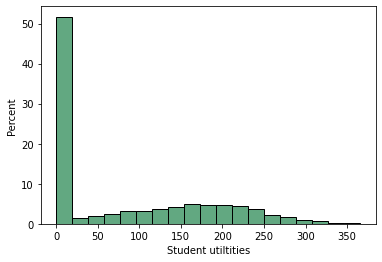

In [89]:
student_utilities_baseline = [s.get_utilities() for s in student_list_baseline]
total_welfare_baseline = sum(student_utilities_baseline)
sns.histplot(student_utilities_baseline, stat = 'percent', color = 'seagreen')
plt.xlabel("Student utiltities")
filename = f"results/fig/utils_baseline_s{n_students}c{n_courses}d{n_depts}cl{credit_limit}el{enroll_limit}k{n_slots}"
plt.savefig(filename)

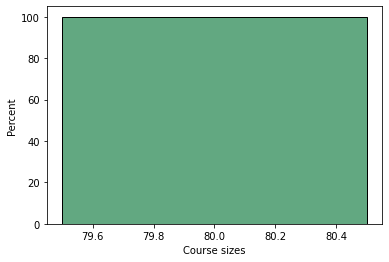

In [90]:
course_enroll_sizes_baseline = [len(c.student_enroll) for c in course_list_baseline]
sns.histplot(course_enroll_sizes_baseline, stat = 'percent', color = 'seagreen')
plt.xlabel("Course sizes")
filename = f"results/fig/csizes_baseline_s{n_students}c{n_courses}d{n_depts}cl{credit_limit}el{enroll_limit}k{n_slots}"
plt.savefig(filename)

In [91]:
print(f"\n\nParameters:")
print(f"\ts={n_students}, c={n_courses}, d={n_depts}, cl={credit_limit}, el={enroll_limit}, k={n_slots}")
print(f"Total welfare:")
print(f"\tproposed method: {total_welfare}")
print(f"\tbaseline: {total_welfare_baseline}")
print(f"\twelfare gain: {total_welfare - total_welfare_baseline}\n")



Parameters:
	s=5000, c=100, d=15, cl=4, el=80, k=12
Total welfare:
	proposed method: 478226
	baseline: 405983
	welfare gain: 72243

